In this notebook, we will make analysis on orders and customers. We will try to answer questions as : where are customers located? How many orders do they do? When/what do customers order ?  
We will join different datasets available at https://www.kaggle.com/olistbr/brazilian-ecommerce. Then we will create variables in a dataset indexed by orders and aggregate it by customers, that will permit us to test our segmentations. We will integrate the RFM variables currently used in marketing and other interesting variables. 

In [1]:
#Import useful packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from functions import *

### Where are customers located ?

In [2]:
# import customers et geolocation datatset
customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')

In [3]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
customers.rename(columns={'customer_city': 'city'}, inplace=True)

In [5]:
#Number of orders
customers.shape[0]

99441

In [6]:
#Number of customers
nb_customers = len(customers.customer_unique_id.unique())
print(nb_customers)

96096


Here we can guess that a majority of customers have ordered only once. 

In [7]:
#Number of orders in each city
customers.city.value_counts()

sao paulo               15540
rio de janeiro           6882
belo horizonte           2773
brasilia                 2131
curitiba                 1521
                        ...  
brejetuba                   1
atalaia                     1
planaltino                  1
macambira                   1
santa luzia do parua        1
Name: city, Length: 4119, dtype: int64

In [8]:
#Proportion of orders in each city
customers.city.value_counts(normalize=True)

sao paulo               0.156274
rio de janeiro          0.069207
belo horizonte          0.027886
brasilia                0.021430
curitiba                0.015296
                          ...   
brejetuba               0.000010
atalaia                 0.000010
planaltino              0.000010
macambira               0.000010
santa luzia do parua    0.000010
Name: city, Length: 4119, dtype: float64

In [9]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [10]:
geolocation.columns=['zip_code', 'lat', 'lng', 'city', 'state']

We create a 'density_city' variable that represents, for each city, the number of customers living in the city divided by the total number of customers

In [11]:
city_density = pd.DataFrame(100
                            * customers.groupby('city')['customer_unique_id']
                            .count()
                            / nb_customers)

In [12]:
city_density.rename(columns={'customer_unique_id': 'city_density'}, inplace=True)

In [13]:
city_density

,city_density
city,
abadia dos dourados,0.003122
abadiania,0.001041
abaete,0.012488
abaetetuba,0.011447
abaiara,0.002081
...,...
xinguara,0.009366
xique-xique,0.003122
zacarias,0.002081


To get an approximation of geographic coordinates for each city, we take the median coordinates of zip codes in the geolocation dataset.

In [14]:
geolocation=geolocation.groupby('city')[['lng', 'lat']].median()

In [15]:
geolocation.head()

,lng,lat
city,,
* cidade,-49.334374,-25.571748
...arraial do cabo,-42.029834,-22.969370
4o. centenario,-53.069433,-24.271860
4º centenario,-53.074723,-24.279801
abadia de goias,-49.435230,-16.766377


In [16]:
#We merge the city density to the geolocation dataset.
geolocation=pd.merge(geolocation, city_density, on='city', how='inner')

In [17]:
geolocation.head()

,lng,lat,city_density
city,,,
abadia dos dourados,-47.404557,-18.483128,0.003122
abadiania,-48.708817,-16.194298,0.001041
abaete,-45.447130,-19.156986,0.012488
abaetetuba,-48.882433,-1.722525,0.011447
abaiara,-39.050108,-7.361572,0.002081


In [18]:
geolocation.shape

(4069, 3)

Let's represent the cities on a map of Brazil, sized par their respective density.

In [19]:
import geopandas as gpd

In [20]:
#we import the shape file containg the map

In [21]:
geo_df = gpd.read_file('my_files/BRA_adm1.shp')

C:\Users\celine\anaconda3\lib\site-packages\geopandas\plotting.py:470: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


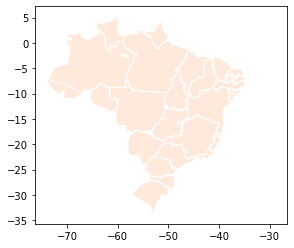

In [22]:
geo_df.plot(column='NAME_1', color='#ffe9da', edgecolor="white")


In [23]:
geolocation.shape

(4069, 3)

We drop the cities with wrong geographic coordinates

In [24]:
geolocation[(geolocation['lng'] > -30) | (geolocation['lat'] > 10)]

,lng,lat,city_density
city,,,
ibiajara,-23.583939,13.001420,0.001041
ilha dos valadares,-8.723762,42.184003,0.001041
porto trombetas,-7.738207,41.656504,0.002081
vila dos cabanos,-27.750555,20.459462,0.004163


In [25]:
geolocation = geolocation[(geolocation['lng'] < -30)]
geolocation = geolocation[(geolocation['lat'] < 10)]

We now overlay map and cities, annotating the four cities with highest density.

In [26]:
geolocation.sort_values('city_density',ascending=False,inplace=True)
geolocation.reset_index(inplace=True)

C:\Users\celine\anaconda3\lib\site-packages\geopandas\plotting.py:470: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


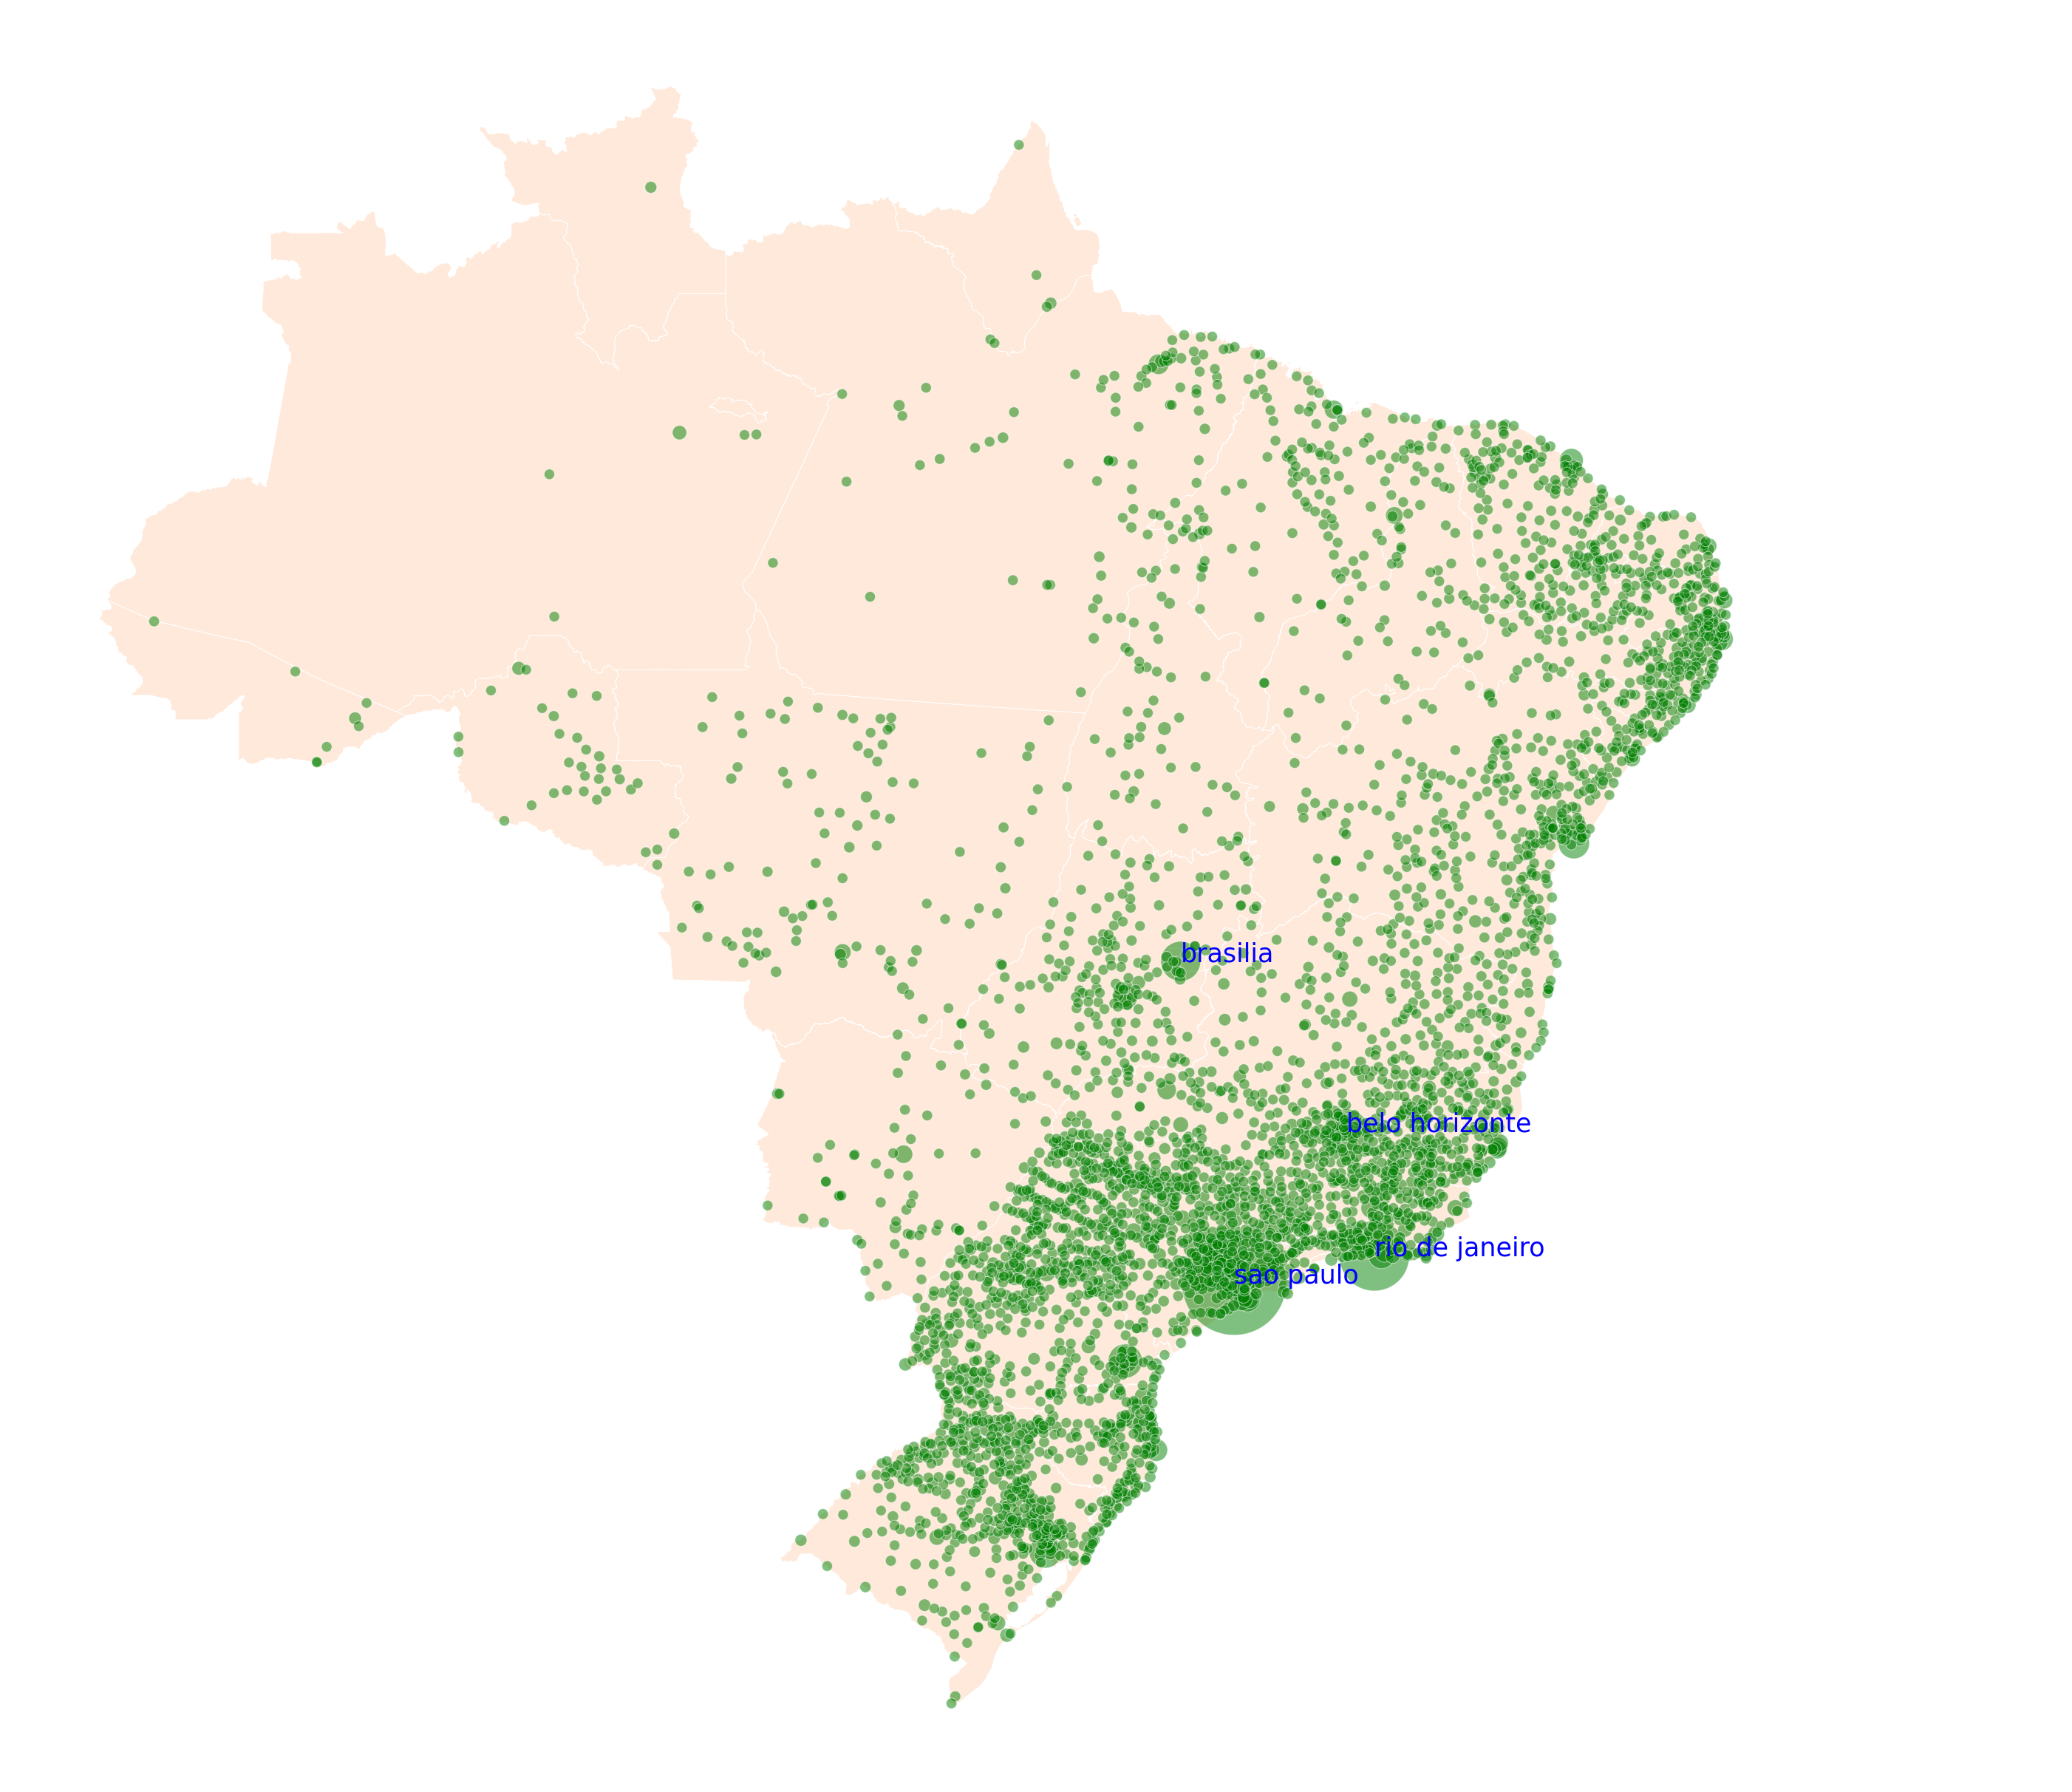

In [27]:
plt.rcParams["figure.figsize"] = (50,50)

# draw the map
geo_df.plot(column='NAME_1',color='#ffe9da',edgecolor="white")

#draw cities
ax=sns.scatterplot(x='lng',y='lat', data=geolocation, size='city_density',
                   sizes=(200, 20000), legend=None, alpha=0.5, 
                   color='green')

#annotate the cities with the four highest densities
for line in range(4):
    ax.text(geolocation.lng[line], geolocation.lat[line], \
             geolocation.city[line], horizontalalignment='left',
             fontsize=35, color='blue')

#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)
plt.axis('off')
plt.show()

We note that we have:  
- More customers in the cities of São Paulo, Rio de Janeiro, Belo Horizonte and Brazilia  
- more customers on the coast than inland. We have very few customers in North West  
- almost no customers in the North West

### How many orders by customers ?

In [28]:
nb_orders = customers.groupby('customer_unique_id')['customer_id'].count()

In [29]:
nb_orders.describe()

count    96096.000000
mean         1.034809
std          0.214384
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         17.000000
Name: customer_id, dtype: float64

In [30]:
nb_orders.describe(percentiles=np.arange(0.9, 1, 0.01))

count    96096.000000
mean         1.034809
std          0.214384
min          1.000000
50%          1.000000
90%          1.000000
91%          1.000000
92%          1.000000
93%          1.000000
94%          1.000000
95%          1.000000
96%          1.000000
97%          2.000000
98%          2.000000
99%          2.000000
max         17.000000
Name: customer_id, dtype: float64

About 96 % of customers have ordered only once. 

### How does the number of orders change over time ?

Let's study the evolution of the number of orders. 

In [31]:
orders = pd.read_csv('olist_orders_dataset.csv')

In [32]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [33]:
orders.shape

(99441, 8)

In [34]:
customers.shape

(99441, 5)

In [35]:
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [36]:
orders['order_purchase_timestamp']=pd.to_datetime(
                                                orders['order_purchase_timestamp']
                                                  )
orders['order_delivered_customer_date']=pd.to_datetime(
                                                orders['order_delivered_customer_date']
                                                  )

In [37]:
orders_d = orders[orders['order_status'] == 'delivered']

In [38]:
orders_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96478 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96478 non-null  object        
 1   customer_id                    96478 non-null  object        
 2   order_status                   96478 non-null  object        
 3   order_purchase_timestamp       96478 non-null  datetime64[ns]
 4   order_approved_at              96464 non-null  object        
 5   order_delivered_carrier_date   96476 non-null  object        
 6   order_delivered_customer_date  96470 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96478 non-null  object        
dtypes: datetime64[ns](2), object(6)
memory usage: 6.6+ MB


In [39]:
orders_d.set_index('order_purchase_timestamp',inplace=True)

In [40]:
orders_d.head()

,order_id,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
order_purchase_timestamp,,,,,,,
2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
2018-02-13 21:18:39,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


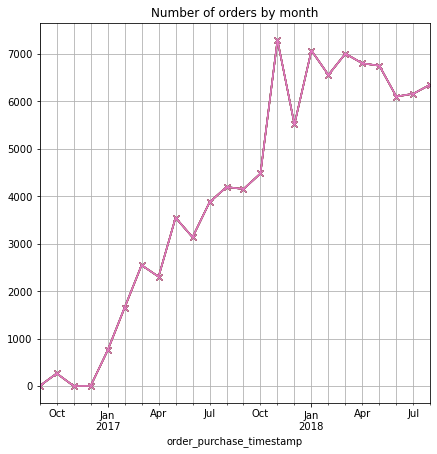

In [41]:
plt.rcParams["figure.figsize"] = (7,7)
orders_d.resample('M').count().plot(title='Number of orders by month',legend=None,marker='x') 
plt.grid('both', which='both')
plt.show()

A peak is noted on november 2017.

Evolution of number of orders by day of the week.

In [42]:
orders_d.reset_index(inplace=True)

In [43]:
orders_d.loc[:,'purchase_day']=orders_d.loc[:,'order_purchase_timestamp'].dt.day_name()

C:\Users\celine\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\celine\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [44]:
orders_d.head()

,order_purchase_timestamp,order_id,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_day
0,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,Monday
1,2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,Tuesday
2,2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,Wednesday
3,2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,Saturday
4,2018-02-13 21:18:39,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,Tuesday


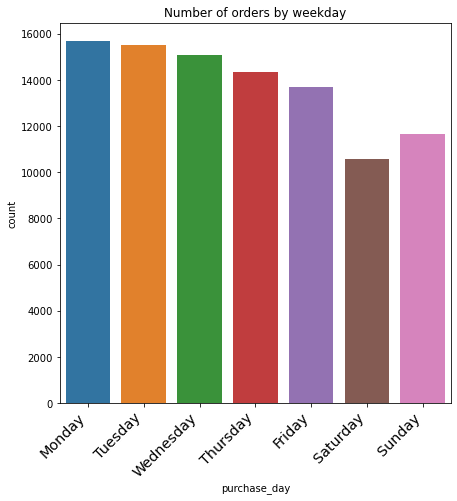

In [45]:
sns.countplot(data=orders_d,
              x='purchase_day',
              order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

plt.xticks(rotation=45, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='x-large'  
            )
plt.title('Number of orders by weekday')
plt.show()

There are slightly fewer orders at weekends.

### Orders characteristics : univariate analysis

#### Number of items by orders

In [46]:
items = pd.read_csv('olist_order_items_dataset.csv')

In [47]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [48]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [49]:
#Number of items in each order
nb_items = items.groupby('order_id')['product_id'].count()


In [50]:
nb_items.describe()

count    98666.000000
mean         1.141731
std          0.538452
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         21.000000
Name: product_id, dtype: float64

In [51]:
nb_items.describe(percentiles=np.arange(0.9, 1, 0.05))

count    98666.000000
mean         1.141731
std          0.538452
min          1.000000
50%          1.000000
90%          1.000000
95%          2.000000
max         21.000000
Name: product_id, dtype: float64

More than 90% of orders contains only one item.

#### Categories of orders

In [52]:
products=pd.read_csv('olist_products_dataset.csv')

In [53]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [54]:
products['dimensions'] = products['product_width_cm']\
                         * products['product_length_cm']\
                         * products['product_width_cm']

In [55]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [56]:
items=pd.merge(items[['order_id','product_id']],\
               products[['product_category_name','dimensions','product_id']],\
               how='left',\
               on='product_id')

We simplify the category name of products

In [57]:
#the category function is defined on functions module
items['category']=items['product_category_name'].apply(category)

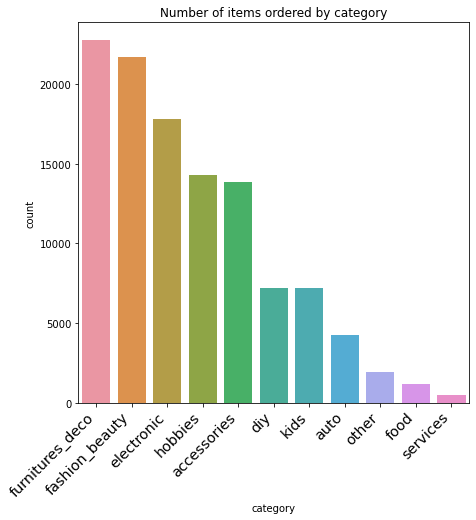

In [58]:
sns.countplot(data=items,
              x='category',
              order=items['category'].value_counts().index)

plt.xticks(rotation=45, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='x-large')

plt.title('Number of items ordered by category')
plt.show()

In [59]:
#median dimensions by category

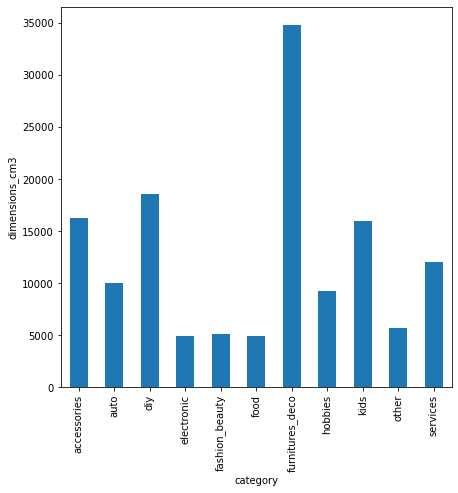

In [60]:
items.groupby('category')['dimensions'].median().plot(kind='bar')
plt.ylabel('dimensions_cm3')
plt.show()

#### Customers satisfaction

In [61]:
reviews = pd.read_csv('olist_order_reviews_dataset.csv')

In [62]:
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [63]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [64]:
reviews.drop_duplicates('order_id').shape

(98673, 7)

In [65]:
orders.shape

(99441, 8)

In [66]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [67]:
orders_reviews=pd.merge(orders[['order_id','customer_id','order_status']],
                        reviews[['review_id','order_id','review_score','review_comment_message']],
                        on='order_id',
                        how='left')

In [68]:
orders_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99992 entries, 0 to 99991
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                99992 non-null  object 
 1   customer_id             99992 non-null  object 
 2   order_status            99992 non-null  object 
 3   review_id               99224 non-null  object 
 4   review_score            99224 non-null  float64
 5   review_comment_message  40977 non-null  object 
dtypes: float64(1), object(5)
memory usage: 5.3+ MB


There are few reviews score missing.

In [69]:
#average score by order
score_orders = pd.DataFrame(reviews.groupby('order_id')['review_score'].mean())

In [70]:
score_orders.reset_index(inplace=True)

In [71]:
score_orders['review_score'].describe()

count    98673.000000
mean         4.086793
std          1.346274
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_score, dtype: float64

C:\Users\celine\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of the average review score by order')

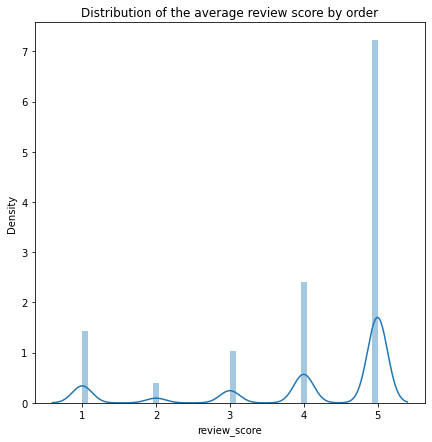

In [72]:
sns.distplot(score_orders['review_score'])
plt.title('Distribution of the average review score by order')

Most of the customers are satisfied.  
Let's see the most frequent word of more than three letters in messages of customers that are unsatisfied. 

In [73]:
#we merge the reviews scores and messages to each customer id
customers_reviews = pd.merge(orders[['order_id','customer_id','order_status']],
                           reviews[['order_id','review_score','review_comment_message']],
                           on='order_id',
                           how='left' )

In [74]:
customers_reviews = pd.merge(customers[['customer_unique_id','customer_id']],
                             customers_reviews,
                             on='customer_id',
                             how='left' )

In [75]:
customers_reviews.head()

,customer_unique_id,customer_id,order_id,order_status,review_score,review_comment_message
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,00e7ee1b050b8499577073aeb2a297a1,delivered,4.0,NaN
1,290c77bc529b7ac935b93aa66c333dc3,18955e83d337fd6b2def6b18a428ac77,29150127e6685892b6eab3eec79f59c7,delivered,5.0,NaN
2,060e732b5b29e8181a18229c7b0b2b5e,4e7b3e00288586ebd08712fdd0374a03,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,5.0,NaN
3,259dac757896d24d7702b9acbbff3f3c,b2b6027bc5c5109e529d4dc6358b12c3,951670f92359f4fe4a63112aa7306eba,delivered,5.0,NaN
4,345ecd01c38d18a9036ed96c73b8d066,4f2d8ab171c80ec8364f7c12e35b23ad,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,5.0,O baratheon è esxelente Amo adoro o baratheon


In [76]:
#define dataset of unsatisfied customers (review score <2)

In [77]:
customers_unsatisfied = customers_reviews[customers_reviews['review_score']<2]

In [78]:
customers_unsatisfied.head()

,customer_unique_id,customer_id,order_id,order_status,review_score,review_comment_message
21,a96d5cfa0d3181817e2b946f921ea021,690172ab319622688d3b4df42f676898,aaff8afa47c8426e414a6d908a97713c,delivered,1.0,Bom dia eu fiz uma compra de 03 peças só mim e...
38,07d190f123147d9e89d4b922543d7948,4c06b42fbf7b97ab10779cda5549cd1c,997fd4b37386d10b57d4ac8cdec011a6,delivered,1.0,"Ainda não recebi o produto. Sendo assim, não p..."
46,233896de79986082f1f479f1f85281cb,f34a6e874087ec1f0e3dab9fdf659c5d,6e98de3a85c84ead6689189b825d35b5,canceled,1.0,Muita demora pra entregar e acima de tudo nao ...
47,a8ae36a2bb6c2bbc3b5d62ede131c9ef,c132855c926907970dcf6f2bf0b33a24,b5172d4a722c0ebb34c29bbbb7a3cb42,invoiced,1.0,Comprei o produto fiz o pagamento na semana qu...
54,d85547cd859833520b311b4458a14c1c,8247b5583327ab8be19f96e1fb82f77b,a6917b5d71e0e9bc434e9228db8daeb2,delivered,1.0,Me mandaram um o relógio que não funciona.. Vo...


In [79]:
customers_unsatisfied.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11424 entries, 21 to 99989
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_unique_id      11424 non-null  object 
 1   customer_id             11424 non-null  object 
 2   order_id                11424 non-null  object 
 3   order_status            11424 non-null  object 
 4   review_score            11424 non-null  float64
 5   review_comment_message  8745 non-null   object 
dtypes: float64(1), object(5)
memory usage: 624.8+ KB


In [80]:
from collections import Counter

In [81]:
def word_freq(data,col,nb=20):
    '''returns the most frequents words of more than three letters in the 'col' column
    '''
    word_count_dict = {}
    lp=list(data[col])
    word_count_dict=Counter()
    
    for i in range(data.shape[0]):
        text=str(lp[i]).lower()
        
        for w in text.split(" "):
            if len(w)>3:
                word_count_dict[w]+=1
                
    return word_count_dict.most_common(nb)

In [82]:
word_freq(customers_unsatisfied,'review_comment_message')

[('produto', 4122),
 ('recebi', 2564),
 ('comprei', 1403),
 ('para', 1293),
 ('ainda', 1075),
 ('veio', 1073),
 ('entrega', 802),
 ('estou', 750),
 ('entregue', 746),
 ('chegou', 733),
 ('mais', 589),
 ('muito', 584),
 ('compra', 573),
 ('agora', 555),
 ('prazo', 555),
 ('como', 516),
 ('minha', 506),
 ('pedido', 484),
 ('loja', 460),
 ('apenas', 432)]

Among the most frequent words, we note 'produto' (product) and 'recebi' (received).

#### Delivery number of days

In [83]:
orders_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96478 entries, 0 to 96477
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_purchase_timestamp       96478 non-null  datetime64[ns]
 1   order_id                       96478 non-null  object        
 2   customer_id                    96478 non-null  object        
 3   order_status                   96478 non-null  object        
 4   order_approved_at              96464 non-null  object        
 5   order_delivered_carrier_date   96476 non-null  object        
 6   order_delivered_customer_date  96470 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96478 non-null  object        
 8   purchase_day                   96478 non-null  object        
dtypes: datetime64[ns](2), object(7)
memory usage: 6.6+ MB


In [84]:
# We define the new variable delivery number of days
orders_d.loc[:,'delivery_nb_of_days'] = (orders_d.loc[:,'order_delivered_customer_date']
                                        - orders_d.loc[:,'order_purchase_timestamp'])\
                                        .dt.days

C:\Users\celine\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\celine\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [85]:
orders_d.head()

,order_purchase_timestamp,order_id,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_day,delivery_nb_of_days
0,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,Monday,8.0
1,2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,Tuesday,13.0
2,2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,Wednesday,9.0
3,2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,Saturday,13.0
4,2018-02-13 21:18:39,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,Tuesday,2.0


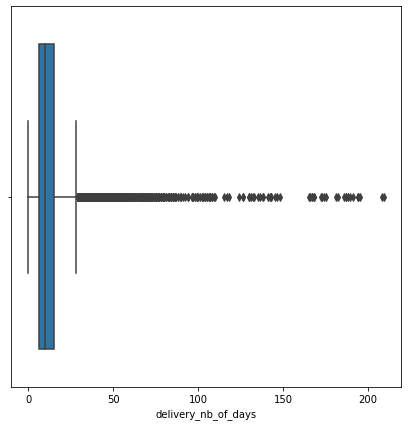

In [86]:
sns.boxplot(data=orders_d,x='delivery_nb_of_days')
plt.show()

In [87]:
orders_d.delivery_nb_of_days.describe(percentiles=np.arange(0.8,1,0.05))

count    96470.000000
mean        12.093604
std          9.551380
min          0.000000
50%         10.000000
80%         17.000000
85%         19.000000
90%         23.000000
95%         29.000000
max        209.000000
Name: delivery_nb_of_days, dtype: float64

Some orders have a delivery number of days of more than 100 days !

#### Payments

In [88]:
payments = pd.read_csv('olist_order_payments_dataset.csv')
payments.set_index('order_id',inplace=True,drop=True)


In [89]:
payments.head()

,payment_sequential,payment_type,payment_installments,payment_value
order_id,,,,
b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


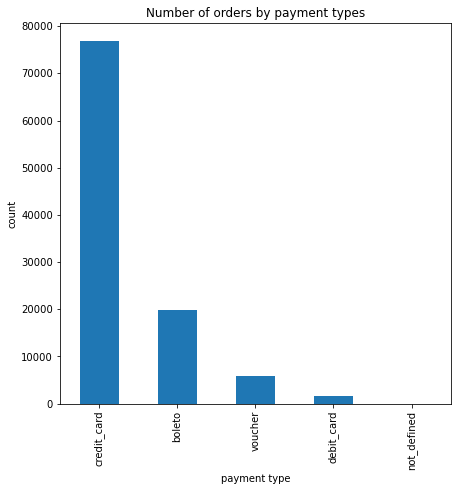

In [90]:
payments['payment_type'].value_counts().plot(kind='bar')
plt.title('Number of orders by payment types')
plt.xlabel('payment type')
plt.ylabel('count')
plt.show()

Customers pay mainly by credit card.

#### Payment value distribution

In [97]:
payments['payment_value'].describe()

count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
25%          56.790000
50%         100.000000
75%         171.837500
max       13664.080000
Name: payment_value, dtype: float64

C:\Users\celine\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


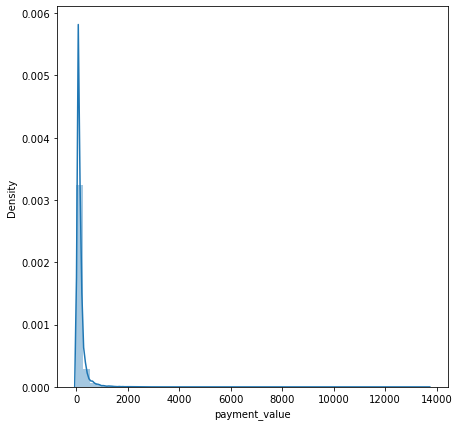

In [98]:
sns.distplot(payments['payment_value'])
plt.show()

#### Number of payments

First, for each order, we count the number of times a payment type has been used and the total payment value.

In [99]:
payment_types = pd.get_dummies(payments[['payment_type','payment_value']])
payment_types = payment_types.groupby('order_id').sum()

In [100]:
payment_types

,payment_value,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher
order_id,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,72.19,0,1,0,0,0
00018f77f2f0320c557190d7a144bdd3,259.83,0,1,0,0,0
000229ec398224ef6ca0657da4fc703e,216.87,0,1,0,0,0
00024acbcdf0a6daa1e931b038114c75,25.78,0,1,0,0,0
00042b26cf59d7ce69dfabb4e55b4fd9,218.04,0,1,0,0,0
...,...,...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,343.40,1,0,0,0,0
fffcd46ef2263f404302a634eb57f7eb,386.53,1,0,0,0,0
fffce4705a9662cd70adb13d4a31832d,116.85,0,1,0,0,0


In [101]:
payment_types['nb_payments'] = payment_types['payment_type_boleto']\
                               + payment_types['payment_type_credit_card']\
                               + payment_types['payment_type_debit_card']\
                               + payment_types['payment_type_voucher']

In [102]:
payment_types

,payment_value,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,nb_payments
order_id,,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,72.19,0,1,0,0,0,1
00018f77f2f0320c557190d7a144bdd3,259.83,0,1,0,0,0,1
000229ec398224ef6ca0657da4fc703e,216.87,0,1,0,0,0,1
00024acbcdf0a6daa1e931b038114c75,25.78,0,1,0,0,0,1
00042b26cf59d7ce69dfabb4e55b4fd9,218.04,0,1,0,0,0,1
...,...,...,...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,343.40,1,0,0,0,0,1
fffcd46ef2263f404302a634eb57f7eb,386.53,1,0,0,0,0,1
fffce4705a9662cd70adb13d4a31832d,116.85,0,1,0,0,0,1


Distribution number of payments

In [103]:
payment_types['nb_payments'].describe(np.arange(0,1,0.1))

count    99440.000000
mean         1.044680
std          0.381209
min          0.000000
0%           0.000000
10%          1.000000
20%          1.000000
30%          1.000000
40%          1.000000
50%          1.000000
60%          1.000000
70%          1.000000
80%          1.000000
90%          1.000000
max         29.000000
Name: nb_payments, dtype: float64

Distribution of payment values

In [104]:
payment_types['payment_value'].describe()

count    99440.000000
mean       160.990267
std        221.951257
min          0.000000
25%         62.010000
50%        105.290000
75%        176.970000
max      13664.080000
Name: payment_value, dtype: float64

### Feature engineering

We merge useful variables for future analysis or segmentations.

In [105]:
# We merge customers et orders informations 
df = pd.merge(customers[['customer_id',
                         'customer_unique_id',
                         'city']],
              orders_d[['order_id',
                        'customer_id',
                        'order_purchase_timestamp',
                        'order_delivered_customer_date',
                        'delivery_nb_of_days']],
              on='customer_id',
              how='inner')

In [106]:
# we create the variable number of days since order.
lastdate=df['order_purchase_timestamp'].max()
df['nb_days_since_order']=(lastdate-df['order_purchase_timestamp']).dt.days

In [107]:
df.head()

,customer_id,customer_unique_id,city,order_id,order_purchase_timestamp,order_delivered_customer_date,delivery_nb_of_days,nb_days_since_order
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05-25 10:35:35,8.0,469
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018-01-29 12:41:19,16.0,228
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018-06-14 17:58:51,26.0,101
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,2018-03-28 16:04:25,14.0,168
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,campinas,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,2018-08-09 20:55:48,11.0,31


In [108]:
#We join payments informations of each order
df = pd.merge(df,payment_types,on='order_id',how='left')

In [109]:
#then, we join the number of items in each order
df = pd.merge(df,nb_items,on='order_id',how='left')

In [110]:
df.rename(columns={'product_id': 'nb_items'},inplace=True)

In [111]:
df.head()

,customer_id,customer_unique_id,city,order_id,order_purchase_timestamp,order_delivered_customer_date,delivery_nb_of_days,nb_days_since_order,payment_value,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,nb_payments,nb_items
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05-25 10:35:35,8.0,469,146.87,0.0,1.0,0.0,0.0,0.0,1.0,1
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018-01-29 12:41:19,16.0,228,335.48,0.0,1.0,0.0,0.0,0.0,1.0,1
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018-06-14 17:58:51,26.0,101,157.73,0.0,1.0,0.0,0.0,0.0,1.0,1
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,2018-03-28 16:04:25,14.0,168,173.30,0.0,1.0,0.0,0.0,0.0,1.0,1
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,campinas,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,2018-08-09 20:55:48,11.0,31,252.25,0.0,1.0,0.0,0.0,0.0,1.0,1


In [112]:
#Now we will join informations on categories and dimensions of items

#We Get the categories and dimensions of each items
products_orders = pd.merge(items[['product_id',
                                'order_id']],
                         products[['product_id',
                                   'product_category_name',
                                   'dimensions']],
                         on='product_id',
                         how='inner')

products_orders['category'] = products_orders['product_category_name']\
                             .apply(category)


products_orders.set_index('order_id',inplace=True)

products_orders = pd.get_dummies(products_orders[['category','dimensions']])

# we group by orders ids to define the number of items in each category and the mean dimensions of items.
products_orders = products_orders.groupby('order_id')\
                .agg({'dimensions': 'mean',
                      'category_other': 'sum',
                      'category_kids': 'sum',
                      'category_hobbies': 'sum',
                      'category_furnitures_deco': 'sum',
                      'category_food': 'sum',
                      'category_fashion_beauty': 'sum',
                      'category_electronic': 'sum',
                      'category_diy': 'sum',
                      'category_auto': 'sum',
                      'category_accessories': 'sum',
                      'category_services': 'sum',
                      'category_other': 'sum'
                      })
#finally, we join product_orders to df.
df = pd.merge(df,products_orders,on='order_id',how='left')

In [113]:
# We join mean review scores by orders
df = pd.merge(df,score_orders,on='order_id',how='left')

In [114]:
# we join city density
df = pd.merge(df,city_density,how='left',on='city')

In [115]:
df.head()

,customer_id,customer_unique_id,city,order_id,order_purchase_timestamp,order_delivered_customer_date,delivery_nb_of_days,nb_days_since_order,payment_value,payment_type_boleto,...,category_furnitures_deco,category_food,category_fashion_beauty,category_electronic,category_diy,category_auto,category_accessories,category_services,review_score,city_density
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05-25 10:35:35,8.0,469,146.87,0.0,...,1,0,0,0,0,0,0,0,4.0,0.167541
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018-01-29 12:41:19,16.0,228,335.48,0.0,...,0,0,0,0,0,0,1,0,5.0,0.976107
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018-06-14 17:58:51,26.0,101,157.73,0.0,...,1,0,0,0,0,0,0,0,5.0,16.171329
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,2018-03-28 16:04:25,14.0,168,173.30,0.0,...,1,0,0,0,0,0,0,0,5.0,0.398560
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,campinas,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,2018-08-09 20:55:48,11.0,31,252.25,0.0,...,1,0,0,0,0,0,0,0,5.0,1.502664


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96478 entries, 0 to 96477
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    96478 non-null  object        
 1   customer_unique_id             96478 non-null  object        
 2   city                           96478 non-null  object        
 3   order_id                       96478 non-null  object        
 4   order_purchase_timestamp       96478 non-null  datetime64[ns]
 5   order_delivered_customer_date  96470 non-null  datetime64[ns]
 6   delivery_nb_of_days            96470 non-null  float64       
 7   nb_days_since_order            96478 non-null  int64         
 8   payment_value                  96477 non-null  float64       
 9   payment_type_boleto            96477 non-null  float64       
 10  payment_type_credit_card       96477 non-null  float64       
 11  payment_type_de

### Correlation matrix

In [117]:
data=df.select_dtypes(include='number')

In [233]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96478 entries, 0 to 96477
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   delivery_nb_of_days       96470 non-null  float64
 1   nb_days_since_order       96478 non-null  int64  
 2   payment_value             96477 non-null  float64
 3   payment_type_boleto       96477 non-null  float64
 4   payment_type_credit_card  96477 non-null  float64
 5   payment_type_debit_card   96477 non-null  float64
 6   payment_type_not_defined  96477 non-null  float64
 7   payment_type_voucher      96477 non-null  float64
 8   nb_payments               96477 non-null  float64
 9   nb_items                  96478 non-null  int64  
 10  dimensions                96462 non-null  float64
 11  category_other            96478 non-null  uint8  
 12  category_kids             96478 non-null  uint8  
 13  category_hobbies          96478 non-null  uint8  
 14  catego

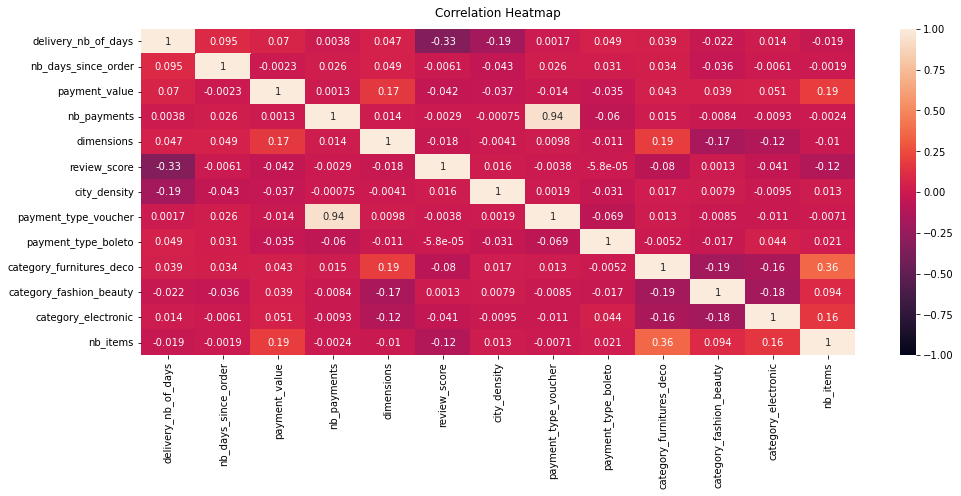

In [234]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data[['delivery_nb_of_days',
                            'nb_days_since_order',
                            'payment_value',
                            'nb_payments',
                            'dimensions',
                            'review_score',
                            'city_density',
                            'payment_type_voucher',
                            'payment_type_boleto',
                            'category_furnitures_deco',
                            'category_fashion_beauty',
                            'category_electronic',
                            'nb_items']].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Data preprocessing

We preprare the dataset for segmentation.

In [237]:
dg_init=df.groupby('customer_unique_id').agg({#For each customer, we calculate
                                              # the number of orders
                                              'order_id': 'count', 
                                            
                                               # the average nb of uses of each payment type
                                              'payment_type_boleto': 'mean',
                                              'payment_type_debit_card': 'mean',
                                              'payment_type_credit_card': 'mean',
                                              'payment_type_voucher': 'mean',
                                            
                                               # the average number of payments
                                              'nb_payments': 'mean',
                                            
                                               # the number of days since last order
                                              'nb_days_since_order': 'min',
                                         
                                               # the average delivery number of days
                                              'delivery_nb_of_days': 'mean',
                                            
                                               # the average payment value
                                              'payment_value': 'mean',
                                            
                                               # the average number of items 
                                              'nb_items': 'mean',
                                            
                                               # the average review score
                                              'review_score': 'mean',
                                            
                                               # the customer's city density 
                                               'city_density': lambda x: x.max(),
                                         
                                               # the average number of items for each category
                                               'category_other': 'mean',
                                               'category_kids': 'mean',
                                               'category_hobbies': 'mean',
                                               'category_furnitures_deco': 'mean',
                                               'category_food': 'mean',
                                               'category_fashion_beauty': 'mean',
                                               'category_electronic': 'mean',
                                               'category_diy': 'mean',
                                               'category_auto': 'mean',
                                               'category_services': 'mean',
                                               'category_accessories': 'mean',
                                          
                                               # the average dimension of items
                                               'dimensions': 'mean'
                                          })

In [238]:
dg_init.rename(columns={'order_id': 'nb_of_orders',
                        'nb_days_since_order': 'nb_days_since_last_order'
                       },
                inplace=True)

In [239]:
dg_init=dg_init.dropna()

In [240]:
dg_init.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92733 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   nb_of_orders              92733 non-null  int64  
 1   payment_type_boleto       92733 non-null  float64
 2   payment_type_debit_card   92733 non-null  float64
 3   payment_type_credit_card  92733 non-null  float64
 4   payment_type_voucher      92733 non-null  float64
 5   nb_payments               92733 non-null  float64
 6   nb_days_since_last_order  92733 non-null  int64  
 7   delivery_nb_of_days       92733 non-null  float64
 8   payment_value             92733 non-null  float64
 9   nb_items                  92733 non-null  float64
 10  review_score              92733 non-null  float64
 11  city_density              92733 non-null  float64
 12  category_other            92733 non-null  float64
 13  category

Finally, we export datasets.

In [241]:
dg_init.to_pickle('dataset_segmentation.pkl')

In [242]:
df.to_pickle('df_orders.pkl')